In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.spatial import distance
import warnings
warnings.simplefilter('ignore')
import time
import datetime

from IPython.display import clear_output, Image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix 
from tqdm import tqdm, tqdm_notebook, trange
from matplotlib.ticker import MaxNLocator

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KDTree, DistanceMetric
from sklearn.metrics import accuracy_score

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#train_full = pd.read_csv("MNIST_train.csv")

colnames = ["dig"] + [i for i in range(1, 28*28+1)]
train = pd.read_csv("MNIST_train_small.csv", names=colnames)
test = pd.read_csv("MNIST_test_small.csv", names=colnames)

In [3]:
train.head()

,dig,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# test.head()

In [5]:
train.shape, test.shape

((3000, 785), (1000, 785))

### (a) Implementation

 Implementation with a KDTree

In [6]:
# tree = KDTree(train.values[:,1:], metric=DistanceMetric.get_metric("minkowski", p=2))

In [7]:
def predict_test_with_KDtree(train_data, test_data, k, p=2, tree=None, exclude_nearest=False):
    
    if not tree:
        tree = KDTree(train_data[:,1:], metric=DistanceMetric.get_metric("minkowski", p=p))
        
    actual = []
    predictions = []
    
    for test_digit in test_data:
        _, ind = tree.query(test_digit[1:].reshape(1, -1), k=k)
        neighboring_digits = [dig[0] for dig in train_data[ind][0]]
        
        if exclude_nearest:
            neighboring_digits = neighboring_digits[1:]
            
        predicted_digit = max(set(neighboring_digits), key = neighboring_digits.count) 
        
        actual.append(test_digit[0])
        predictions.append(predicted_digit)

    return actual, predictions

In [8]:
# act, preds = predict_test_with_KDtree(train.values, test.values, 5, 2)

In [9]:
# accuracy_score(act, preds)

(a) Results for $k$ in $\{ 1, ..., 20 \}$.

Test accuracy/loss

In [27]:
# Test accuracy/loss
ks = range(1, 21)
accs = []
loss_values = []

for k in tqdm_notebook(ks):
    act, preds = predict_test_with_KDtree(train.values, test.values, k, 2)
    accuracy = accuracy_score(act, preds)

    accs.append(accuracy)
    loss_values.append(1-accuracy)

The best accuracy (0.922) on the TEST set is achieved with k = 3 


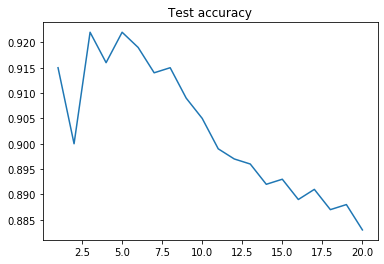

In [28]:
plt.plot(ks, accs);
plt.title("Test accuracy");
print(f"The best accuracy ({max(accs)}) on the TEST set is achieved with k = {ks[np.argmax(accs)]} ")

The minimum loss (0.07799999999999996) on the TEST set is achieved with k = 3 


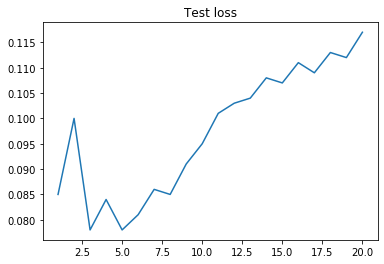

In [29]:
plt.plot(ks, loss_values);
plt.title("Test loss");
print(f"The minimum loss ({min(loss_values)}) on the TEST set is achieved with k = {ks[np.argmin(loss_values)]} ")

In [30]:
# Test accuracy/loss
tab_test_metrics = pd.DataFrame(data={"k": ks, "accuaracy": accs, "loss": loss_values})
tab_test_metrics

,k,accuaracy,loss
0,1,0.91500,0.08500
1,2,0.90000,0.10000
2,3,0.92200,0.07800
3,4,0.91600,0.08400
4,5,0.92200,0.07800
5,6,0.91900,0.08100
6,7,0.91400,0.08600
7,8,0.91500,0.08500
8,9,0.90900,0.09100
9,10,0.90500,0.09500


Train accuracy/loss

In [31]:
# Train accuracy/loss
ks = range(1, 21)
accs = []
loss_values = []

tree = KDTree(train.values[:,1:], metric=DistanceMetric.get_metric("minkowski", p=2))

for k in tqdm_notebook(ks):
    act, preds = predict_test_with_KDtree(train.values, train.values, k, None, tree, exclude_nearest=False)
    accuracy = accuracy_score(act, preds)

    accs.append(accuracy)
    loss_values.append(1-accuracy)

The best accuracy (1.0) on the TRAIN set is achieved with k = 1 


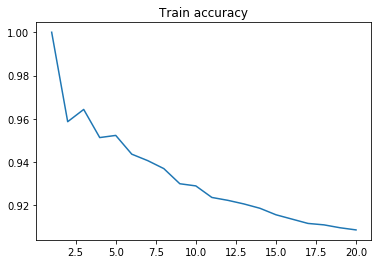

In [32]:
plt.plot(ks, accs);
plt.title("Train accuracy");
print(f"The best accuracy ({max(accs)}) on the TRAIN set is achieved with k = {ks[np.argmax(accs)]} ")

The minimum loss (0.0) on the TRAIN set is achieved with k = 1 


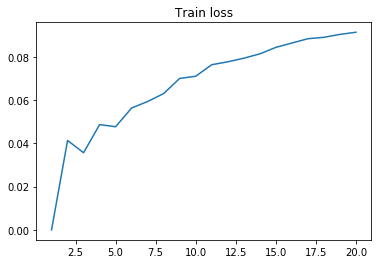

In [33]:
plt.plot(ks, loss_values);
plt.title("Train loss");
print(f"The minimum loss ({min(loss_values)}) on the TRAIN set is achieved with k = {ks[np.argmin(loss_values)]} ")

In [34]:
# Train accuracy/loss
tab_train_metrics = pd.DataFrame(data={"k": ks, "accuaracy": accs, "loss": loss_values})
tab_train_metrics

,k,accuaracy,loss
0,1,1.00000,0.00000
1,2,0.95867,0.04133
2,3,0.96433,0.03567
3,4,0.95133,0.04867
4,5,0.95233,0.04767
5,6,0.94367,0.05633
6,7,0.94067,0.05933
7,8,0.93700,0.06300
8,9,0.93000,0.07000
9,10,0.92900,0.07100


**??? Explain how ties are broken in Equation 1. ???**

### (b) Leave-One-Out Cross-Validation

In [20]:
p = 2
####

ks = range(1, 21)
accs = []
loss_values = []

tree = KDTree(train.values[:,1:], metric=DistanceMetric.get_metric("minkowski", p=p))

for k in tqdm_notebook(ks):
    act, preds = predict_test_with_KDtree(train.values, train.values, k+1, None, tree, exclude_nearest=True)
    accuracy = accuracy_score(act, preds)

    accs.append(accuracy)
    loss_values.append(1-accuracy)

The best LOOCV accuracy (0.9223333333333333) (using only TRAIN set) is achieved with k = 3


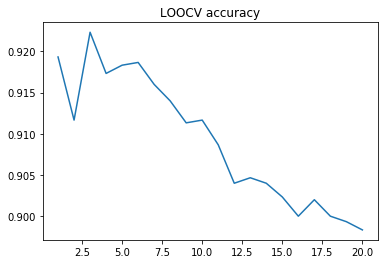

In [22]:
plt.plot(ks, accs);
plt.title("LOOCV accuracy");
print(f"The best LOOCV accuracy ({max(accs)}) (using only TRAIN set) is achieved with k = {ks[np.argmax(accs)]}")

The minimum LOOCV loss (0.07766666666666666) is achieved with k = 3 


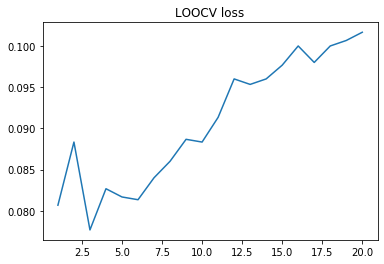

In [25]:
plt.plot(ks, loss_values);
plt.title("LOOCV loss");
print(f"The minimum LOOCV loss ({min(loss_values)}) is achieved with k = {ks[np.argmin(loss_values)]} ")

In [ ]:
# LOOCV accuracy/loss
tab_loocv_metrics = pd.DataFrame(data={"k": ks, "accuaracy": accs, "loss": loss_values})
tab_loocv_metrics

In [ ]:
fig, ax = plt.subplots()
plt.title("Empirical loss for train set using LOOCV and for test set");
plt.plot(ks, tab_test_metrics['loss'], '-o', label='test loss');
plt.plot(ks, tab_loocv_metrics['loss'], '-o', label='loocv loss');
plt.legend();
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# k=3 looks like the best value, chosen on cross-validation

,k,accuaracy,loss
0,1,0.91933,0.08067
1,2,0.91167,0.08833
2,3,0.92233,0.07767
3,4,0.91733,0.08267
4,5,0.91833,0.08167
5,6,0.91867,0.08133
6,7,0.91600,0.08400
7,8,0.91400,0.08600
8,9,0.91133,0.08867
9,10,0.91167,0.08833


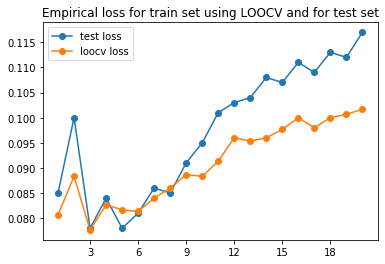

In [80]:
fig, ax = plt.subplots()
plt.title("Empirical loss for train set using LOOCV and for test set");
plt.plot(ks, tab_test_metrics['loss'], '-o', label='test loss');
plt.plot(ks, tab_loocv_metrics['loss'], '-o', label='loocv loss');
plt.legend();
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# k=3 looks like the best value, chosen on cross-validation

# ------------------------- NOTES --------------------------